### Meanshift clustering algorithm - LSH and GPU acceleration
Implementation of the meanshift clustering algorithm using tensor broadcasting and gpu acceleration - FastAI22p2

In [1]:
import math
import matplotlib.pyplot as plt
import operator
import torch
from functools import partial

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
plt.rcParams['figure.figsize'] = [4.0, 3.0]
plt.rcParams['font.size'] = 8

In [4]:
torch.manual_seed(11)
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)

#### create the data

In [5]:
n_clusters = 5
n_samples = 300

In [6]:
centroids = torch.rand(n_clusters, 2)*100-50

In [7]:
centroids

tensor([[-35.09583,  -1.34469],
        [ 48.56615, -33.15986],
        [  8.39434,  19.35992],
        [  8.30849, -37.15622],
        [  7.21227,  42.48394]])

In [8]:
centroids.shape

torch.Size([5, 2])

In [9]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

>We'll use a multivariate normal distribution, here bivariate, to generate points $(x_i, y_i)$ around the centroids, the variables won't be correlated so the covariance matrix should be diagonal, with variance $v$ each:<br>
*(The first argument is the mean, ie a centroid, and the second argument is the covariance matrix (here diagonal), then in the sample() method we specify the number of points to draw around this mean with the variance given in the covariance matrix)*

In [10]:
v = 30.0
u = MultivariateNormal(centroids[0], torch.diag(tensor([v,v])))

In [11]:
g = u.sample((n_samples,))

In [12]:
g.shape

torch.Size([300, 2])

In [13]:
def sample(m, v): return MultivariateNormal(m, torch.diag(tensor([v,v]))).sample((n_samples,))

In [14]:
v = 11.

In [15]:
clouds = [sample(c, v) for c in centroids]
data = torch.cat(clouds)
data.shape

torch.Size([1500, 2])

In [16]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: fig,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        sample = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(sample[:,0], sample[:,1], s=1, alpha=0.5)
        ax.plot(*centroid, markersize=7, marker='x', color='k', mew=5)
        ax.plot(*centroid, markersize=3, marker='x', color='orange', mew=1)

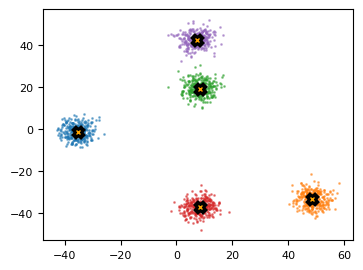

In [17]:
plot_data(centroids, data, n_samples)

#### Mean Shift
> This algorithm does not need to know the number of centroids in advance, it requires a **bandwidth**, similarly to dbscan. <br>
And it works with clusters of any shape.

> What we are looking to do is measure the distance between each point and the rest of the points and weight each two-by-two distance with the gaussian. A neighbor point will have a weight closer to 1 vs a far away point will have a weight tht tends towards 0.

> We can try various function shapes and see how they compare in efficiency. If we want the weighting to be normed, the function should integrate to 1

> Then, we will assign the weighted average x and weighted average

In [18]:
#barycentre
data.mean(0)

tensor([ 7.36041, -1.81920])

> We typically use a gaussian function: <br>
\begin{equation*}
\mathcal{N}(0,\,\sigma^{2}) = \frac{1}{\sqrt{2\pi} \sigma} \exp \left(-{\frac{x^2}{2\sigma^2}}\right)
\end{equation*}

>But other functions can work as well. The gaussian's standard deviation will be the bandwidth, meaning the characteristic distance within which a point will have an impact in the weighted sum. Another possibility would be to use a trianfular function, an inverse function, or a decreasing exponential function.

In [19]:
def gaussian(x, sig=2.5) : 
    return 1/(sig*(2*math.pi)**(0.5)) * torch.exp(-0.5*(x/sig)**2)

In [20]:
def tri(x, i=8):
    return (-(abs(x)/i)+1).clamp_min(0)

In [21]:
def exp_n(x, t=2.5):
    return torch.exp(-abs(x)/t)

In [22]:
def plot_func(f):
    x = torch.linspace(0,50,100)
    plt.plot(x, f(x))

> In order to use partially defined function as input of `plot_func()` we can use the `partial` method from `functools`. We can pass in the function name and specify the attributes we want to fix:

In [23]:
partial

functools.partial

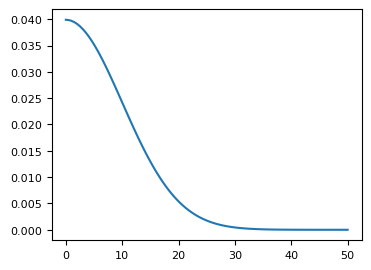

In [24]:
plot_func(partial(gaussian, sig=10))

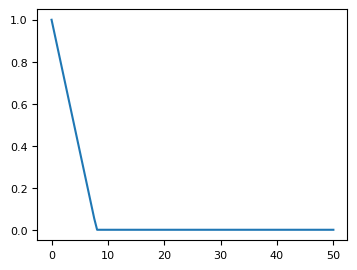

In [25]:
plot_func(tri)

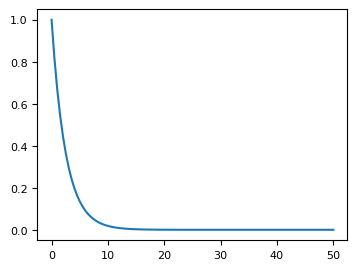

In [26]:
plot_func(partial(exp_n,t=2.5))

Just to have an idea of the time each filter function takes:

In [27]:
%timeit -n 10 tri(data,0.1)

The slowest run took 10.45 times longer than the fastest. This could mean that an intermediate result is being cached.
44.8 µs ± 62 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%timeit -n 10 gaussian(data,0.1)

The slowest run took 4.45 times longer than the fastest. This could mean that an intermediate result is being cached.
91.2 µs ± 70.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%timeit -n 10 exp_n(data, 10)

The slowest run took 15.38 times longer than the fastest. This could mean that an intermediate result is being cached.
43.9 µs ± 69.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Build the algorithm

In [27]:
X = data.clone()
X = X[torch.randperm(X.shape[0])]
x = data[0]

In [28]:
x.shape, X.shape, (x-X).shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1500, 2]))

>We can use a loop to calculate all values from the matrix X:

In [29]:
%%timeit
dist = torch.zeros(X.shape[0], X.shape[0])
for i,x in enumerate(X):
    dist[i] = ((x-X)**2).sum(1).sqrt()

60.4 ms ± 501 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


> We can remove the loop and fasten the process by using a complete vectorial calculation:

In [30]:
X[...,None].shape, X.shape

(torch.Size([1500, 2, 1]), torch.Size([1500, 2]))

In [34]:
%timeit -n 2 ((X[...,None]-X.transpose(0,1))**2).sum(1).sqrt()

13.9 ms ± 2.19 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


> In order to remove the transpose step we can add the empty axis in between, the same broadcasting rule will apply:

In [31]:
X[:,None,:].shape, X.shape

(torch.Size([1500, 1, 2]), torch.Size([1500, 2]))

In [36]:
%timeit -n 2 ((X[:,None,:]-X)**2).sum(2).sqrt()

18.8 ms ± 7.98 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [32]:
X[None].shape, X[:,None].shape

(torch.Size([1, 1500, 2]), torch.Size([1500, 1, 2]))

In [38]:
%timeit -n 2 ((X[None]-X[:,None])**2).sum(2).sqrt()

19 ms ± 8.37 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


> We can try with `torch.einsum` as well:

In [39]:
%%timeit -n 2
Xt = torch.einsum('ij->ji', X)
Diff2 = (X[...,None] - Xt)**2
Dist = torch.einsum('ijk->ik', Diff2).sqrt()

14 ms ± 4.32 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [40]:
%timeit -n 2 Dist = torch.einsum('ijk->ik', (X[...,None] - torch.einsum('ij->ji', X))**2).sqrt()

13.4 ms ± 4.18 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [41]:
%timeit -n 2 torch.sqrt(torch.einsum('ijk->ij',(X[:,None,:] - X)**2))

13.8 ms ± 5.42 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


> We can add the square step in einsum and the performance is the best:

In [42]:
%%timeit -n 10
Diff = X[:,None,:] - X
torch.sqrt(torch.einsum('ijk,ijk->ij',Diff,Diff))

19.9 ms ± 3.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
%%timeit -n 10
Diff = X[None] - X[:,None]
torch.sqrt(torch.einsum('ijk,ijk->ij',Diff,Diff))

9.51 ms ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


> The fastest implementation in a function with the weighting function:

In [33]:
def calculate_weights(X, distrib):
    D = X[:,None,:] - X
    return distrib(torch.sqrt(torch.einsum('ijk,ijk->ij',D,D)))

In [36]:
weights = calculate_weights(X, gaussian)

In [37]:
weights

tensor([[    0.15958,     0.00000,     0.00000,  ...,     0.00000,     0.00000,     0.00000],
        [    0.00000,     0.15958,     0.00000,  ...,     0.00000,     0.00000,     0.00000],
        [    0.00000,     0.00000,     0.15958,  ...,     0.00000,     0.00000,     0.00000],
        ...,
        [    0.00000,     0.00000,     0.00000,  ...,     0.15958,     0.00000,     0.06936],
        [    0.00000,     0.00000,     0.00000,  ...,     0.00000,     0.15958,     0.00000],
        [    0.00000,     0.00000,     0.00000,  ...,     0.06936,     0.00000,     0.15958]])

> The next operation performs the weighted average $\frac{\sum_{i=0}^{n} \omega_i xi}{\sum_{i=0}^{n} \omega_i}$ for each point and replaces the weighted average of $x_i$ and $y_i$ by their new weighted average *(the einsum implementation is again much faster)* :

In [38]:
weights.shape, X.shape

(torch.Size([1500, 1500]), torch.Size([1500, 2]))

In [39]:
(X*weights[...,None]).sum(1).shape, weights.sum(1)[:,None].shape

(torch.Size([1500, 2]), torch.Size([1500, 1]))

In [48]:
%timeit -n 2 ((X*weights[...,None]).sum(1))/(weights.sum(0)[:,None])

The slowest run took 4.24 times longer than the fastest. This could mean that an intermediate result is being cached.
9.72 ms ± 5.43 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [49]:
%timeit -n 2 torch.einsum('jk,ijk->ik', X, weights[...,None])/torch.einsum('ij->j',weights)[:,None]

The slowest run took 8.79 times longer than the fastest. This could mean that an intermediate result is being cached.
5.57 ms ± 3.32 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [40]:
X

tensor([[-27.61908,   5.83527],
        [  4.10980, -36.88531],
        [  9.54503,  21.56147],
        ...,
        [ 47.26237, -39.66573],
        [  6.09354,  41.08786],
        [ 49.79293, -37.66269]])

In [41]:
def calc_w(X, distrib):
    wei_X = torch.zeros(X.shape[0], X.shape[0])
    X_new = torch.zeros_like(X)
    for i,x in enumerate(X):
        dist = ((x-X)**2).sum(1).sqrt()
        weight = gaussian(dist,2.5)
        wei_X[i] = weight
        X_new[i] = (weight[:,None]*X).sum(0)/weight.sum()
    return X_new, wei_X

In [42]:
def update_X(X, W): return (W@X)/torch.einsum('ij->j',W)[:,None]  
# def update_X(X, W): return torch.einsum('jk,ijk->ik', X, W[...,None])/torch.einsum('ij->j',W)[:,None]  
# def update_X(W, X): return((X*W[...,None]).sum(1))/(W.sum(1)[:,None])

In [43]:
r_s,_ = calc_w(X, gaussian)
r_s, _ = calc_w(r_s, gaussian)
r_s

tensor([[-32.88484,   1.45057],
        [  6.75547, -37.12110],
        [  8.62713,  20.06921],
        ...,
        [ 48.56520, -35.72384],
        [  6.95689,  42.25238],
        [ 49.10006, -35.20840]])

In [44]:
w = calculate_weights(X, gaussian)
r_v = update_X(X, w)
w = calculate_weights(r_v, gaussian)
r_v = update_X(r_v, w)
r_v

tensor([[-32.88484,   1.45057],
        [  6.75547, -37.12110],
        [  8.62713,  20.06921],
        ...,
        [ 48.56519, -35.72383],
        [  6.95689,  42.25238],
        [ 49.10005, -35.20839]])

In [45]:
(r_s-r_v).sum()

tensor(0.00020)

In [55]:
%%timeit -n 2
weights = calculate_weights(X, gaussian)
update_X(X, weights)

25.3 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [46]:
def meanshift(data, func):
    X = data.clone()
    for i in range(5):
        weights = calculate_weights(X, func)
        X = update_X(X, weights)
    return X

In [47]:
%timeit -n 2 X=meanshift(data, gaussian)

111 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [47]:
X = meanshift(data, gaussian)

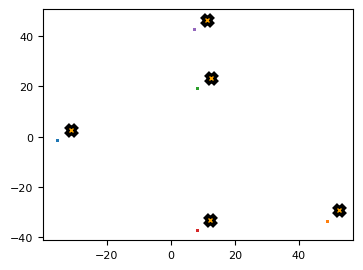

In [48]:
plot_data(centroids+4, X, n_samples)

> We can build the following function that breaks down the operation point by point to verify the results above: <br>
(It is a very slow operation)

In [49]:
# def calc_w(X, distrib):
#     wei_X = torch.zeros(X.shape[0], X.shape[0])
#     X_new = torch.zeros_like(X)
#     for i,x in enumerate(X):
#         dist = ((x-X)**2).sum(1).sqrt()
#         weight = gaussian(dist,2.5)
#         wei_X[i] = weight
#         X_new[i] = (weight[:,None]*X).sum(0)/weight.sum()
#     return X_new, wei_X

In [50]:
# Sequential version with the points position update performed at the end of the full loop
def calc_w(X, distrib):
    X_new = torch.zeros_like(X)
    for i,x in enumerate(X):
        dist = ((x-X)**2).sum(1).sqrt()
        weight = gaussian(dist,2.5)
        X_new[i] = (weight[:,None]*X).sum(0)/weight.sum()
    return X_new

In [51]:
# Jeremy's version with the running update in the for loop
def one_update_(X):
    for i,x in enumerate(X):
        dist = ((x-X)**2).sum(1).sqrt()
        weight = gaussian(dist,2.5)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [62]:
%time calc_w(X, gaussian)

CPU times: user 172 ms, sys: 92 µs, total: 172 ms
Wall time: 171 ms


tensor([[-35.50381,  -1.12512],
        [-35.50381,  -1.12512],
        [-35.50381,  -1.12512],
        ...,
        [  7.27997,  42.73543],
        [  7.27997,  42.73543],
        [  7.27997,  42.73543]])

In [52]:
# A version that uses calc_w to compare the vectorial implementation with a for loop.
def meanshift_slow(data):
    X = data.clone()
    for it in range(4): X = calc_w(X, gaussian)
#     for it in range(3): one_update(X)
    return X

In [64]:
%time _=meanshift_slow(data)

CPU times: user 653 ms, sys: 40 µs, total: 653 ms
Wall time: 652 ms


In [53]:
X = meanshift_slow(data)

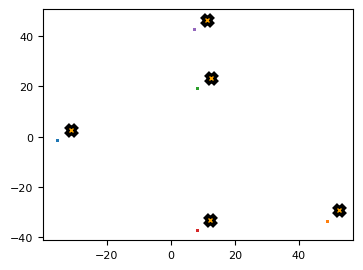

In [54]:
plot_data(centroids+4, X, n_samples)

> Find clusters:

In [55]:
def calculate_weights(X, distrib):
    D = X[:,None,:] - X
    dist = torch.sqrt(torch.einsum('ijk,ijk->ij',D,D))
    return distrib(dist), dist

In [56]:
def meanshift(data, func):
    X = data.clone()
    for i in range(5):
        weights, dist = calculate_weights(X, func)
        X = update_X(X, weights)
    return X, dist

In [57]:
X, dist = meanshift(data, gaussian)

In [58]:
def extract_clusters(X, dist):
    clus_members = {}
    clus_coord = {}
    check_pts = torch.zeros(X.shape[0])
    clu_mat = dist < 0.1
    k = 0
    for i in range(X.shape[0]):
        if check_pts[i]: continue
        idx = torch.where((clu_mat[i].long()@clu_mat.long()))[0]
        clus_members[k] = idx
        clus_coord[k] = X[idx].mean(dim=0)
        check_pts[idx] = 1
        k += 1
    return clus_coord, clus_members

In [59]:
cl_out, cl_pts = extract_clusters(X, dist)
cl_out

{0: tensor([-35.50381,  -1.12512]),
 1: tensor([ 48.71881, -33.46844]),
 2: tensor([ 8.29912, 19.54581]),
 3: tensor([  8.18884, -36.93897]),
 4: tensor([ 7.27997, 42.73543])}

In [60]:
centroids

tensor([[-35.09583,  -1.34469],
        [ 48.56615, -33.15986],
        [  8.39434,  19.35992],
        [  8.30849, -37.15622],
        [  7.21227,  42.48394]])

### We can animate the process

In [61]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [62]:
def one_update(func=gaussian):
    global X
    weights,_ = calculate_weights(X, func)
    X = update_X(X, weights)

In [63]:
def do_one(d):
    if d: one_update()
    ax.clear()
    plot_data(centroids+4, X, n_samples, ax=ax)

In [70]:
X = data.clone()
fig, ax = plt.subplots(figsize=(10,8))
ani = FuncAnimation(fig, do_one, frames=5, interval=550, repeat=False)
plt.close()
# HTML(ani.to_jshtml())
HTML(ani.to_html5_video())

#### Using Locality-Sensitive Hashing and testing Rtrees

> Rtrees should not be of great help here because if we need to use only the nearest neighbors of each points to spare on the distance calculation, the nearest neighbor search is expensive and must be performed at each meanshift iteration since the points coordinates are modified.
Meanshift uses nicely the vectorial speed and replaces the nearest neighbors search by the gaussian distribution and weighted average. A GPU version of this algorithm would be optimal.

> An LSH implementation where the nns are calculated once and stored in memory can be very fast especially for a high dimentional set. <br>
Depending on the GPU implementation, the performance can vary due to the CPU-GPU data transfer. We won't go deep into these questions here (but they are very important to optimize for large datasets).

#### Locality-Sensitive Hashing

In [34]:
n_cent = 5
n_p = 300
cent = torch.rand(n_cent, 2)*180-90
cent.shape, cent

(torch.Size([5, 2]),
 tensor([[ 71.71429,  72.26480],
         [-48.45341, -33.85703],
         [ 46.88916, -75.48917],
         [-75.72447, -67.15977],
         [ 84.09106,  31.25935]]))

In [35]:
def generate_points(c, n_pts, var): return MultivariateNormal(c, torch.diag(tensor([var,var]))).sample((n_pts,))

In [36]:
dat_l = [generate_points(c,n_p,50.) for c in cent]
dat = torch.cat(dat_l)

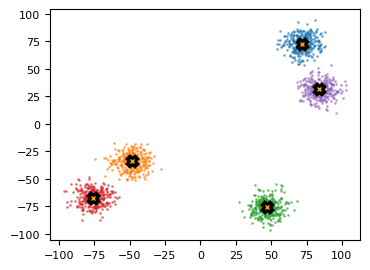

In [37]:
plot_data(cent,dat,n_p)

We can use the Data_Hash class from the `LSH - Locality-Sensitive Hashing` notebook:

In [69]:
class Data_hash():
    def __init__(self, data, dim, n_hash, scale_factor=1, store_hash=False, n_matches=None): 
        self.data, self.d, self.n_h, self.s = (data, dim, n_hash, scale_factor)
        h_t = 2*torch.pi*torch.rand(n_hash)
        if dim == 2: self.h_mat = torch.stack([torch.cos(h_t), -torch.sin(h_t)])
        else: self.h_mat = torch.rand((dim, n_hash))-0.5
        self.h_b = torch.rand(n_hash)
        self.hashed = self._hash(data)
        self.stored = False
        if store_hash:
            self.hash_dict = {}
            if n_matches: 
                self._store(n_matches)
                self._n_matches = n_matches
            else: 
                self._store(n_hash)
                self._n_matches = n_hash
            self.stored=True
        
    def _hash(self, X): return torch.floor(X @ self.h_mat * self.s + self.h_b)
    
    def _store(self, n_matches):
        for t in self.hashed:
            if tuple(t.tolist()) in self.hash_dict.keys(): continue
            k = tuple(t.tolist())
            idx = torch.where((t == self.hashed).sum(1)>n_matches)[0]
            self.hash_dict[k]=idx.tolist()
    
    def find_nns(self, x, n_matches, idx=None):
        # idx is used to find nns in a sub point ensemble given by the indexes 'idx'
        # find_nns will get the stored buckets if they exist and if the n_matches param
        # is equal to the init param n_matches, otherwise it will perform the comparison
        x_hash = self._hash(x)
        if idx!=None :
            v_collide = (x_hash == self.hashed[idx]).sum(1)
            nns = idx[torch.where(v_collide >= n_matches)[0]]
        else:
            if self.stored and n_matches==self._n_matches:
                bucket = self.hash_dict[tuple(x_hash.tolist())]
                return _, torch.tensor(bucket)
            v_collide = (x_hash == self.hashed).sum(1)
            nns = torch.where(v_collide >= n_matches)[0]
        return v_collide, nns 
    
    
    def plot_hd(self):
        fig, ax = plt.subplots(figsize=(3,3))
        xs = torch.linspace(-1.5,1.5,10)
        ax.scatter(*self.h_mat, s=1)
        for i,a in enumerate(self.h_mat[1]/self.h_mat[0]): 
            ax.plot(xs, a*xs, linewidth=1, alpha=0.5, color='C7')
            for j in torch.arange(-5,6):
                b = (self.h_b[i]+j)*(torch.sin(torch.arctan(a))+1/a*torch.cos(torch.arctan(a)))/self.s
                ax.plot(xs, -1/a*xs + b, linewidth=0.5, alpha=0.2, color='C1')
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2);

In [70]:
# X = data.clone()
X = dat.clone()
# X = X[torch.randperm(X.shape[0])]

>We can use the `scale_factor = 0.1`, `n_hash = 20` and `n_matches = 15` values we already used in the `LSH` and `DBSCAN` notebooks that work well for these points densities.

In [62]:
def hash_X(X, n_h, sf=1, store_hash=False, n_matches=15): return Data_hash(X, X.shape[1], n_h, scale_factor=sf, store_hash=store_hash, n_matches=n_matches).hashed

Hashing the data is very fast, it's a matrix multiply, but storing the hashes takes time:

In [73]:
# Just hashing
%timeit -n 5 _ = hash_X(X, 20)

The slowest run took 8.20 times longer than the fastest. This could mean that an intermediate result is being cached.
185 µs ± 222 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [74]:
# Hashing and storing the buckets
%timeit -n 5 _ = hash_X(X, 20, 0.1, True, 15)

71.6 ms ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


We can get the nns matrix with the following tensor calculation:
1. find the hash vaslues that match for each pair of points
2. select only the pairs with more than `n_match` matches

In [75]:
Xh = hash_X(X, 20, 0.2)

In [76]:
Xh[:,None,:].shape, Xh.shape

(torch.Size([1500, 1, 20]), torch.Size([1500, 20]))

In [77]:
# 1.
nns_bool = (Xh[:,None,:] == Xh[None,...])
nns_bool.shape

torch.Size([1500, 1500, 20])

In [89]:
%timeit -n 10 (Xh[:,None,:] == Xh[None,...])

13.7 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [78]:
# 2.
n_match = 15
nns_mat = torch.where(nns_bool.sum(2)>=n_match, 1,0)

In [79]:
def nns_LSH(X_h, n_match):
    nns_bool = (X_h[:,None,:] == X_h[None,...])
    nns_coll = nns_bool.sum(2)
    return nns_coll, torch.where(nns_coll>=n_match, 1,0)

In [92]:
%timeit -n 5 _ = nns_LSH(Xh, n_match)

73.1 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


We can use the `nns_mat` binary matrix as a mask to select the neighbors coordinates by multiplying `X` with it:

In [80]:
nns_mat[...,None].shape, X.shape

(torch.Size([1500, 1500, 1]), torch.Size([1500, 2]))

In [81]:
(nns_mat[...,None]*X).shape, (nns_mat[...,None]*X)[0].shape

(torch.Size([1500, 1500, 2]), torch.Size([1500, 2]))

We can replace `(nns_mat[...,None]*X).sum(1)` by a simple matrix multiply `nns_mat.float()@X`:

In [82]:
((nns_mat[...,None]*X).sum(1) - (nns_mat.float()@X)).mean()

tensor(    -0.00000)

Then perform the sum over the second dim of the resulting tensor and divide by the number of non-zero `(x,y)` pairs:

In [83]:
nns_mat.sum(1).shape

torch.Size([1500])

In [97]:
%timeit -n 2 (nns_mat[...,None]*X).sum(1)/nns_mat.sum(1)[:,None]

10.8 ms ± 5.12 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [101]:
%timeit -n 2 (nns_mat.float()@X)/nns_mat.sum(1)[:,None]

8.1 ms ± 3.28 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [100]:
%timeit -n 2 torch.einsum('ijk,jk->ik', nns_mat[...,None].float(), X)/nns_mat.sum(1)[:,None]

8.21 ms ± 3.93 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [84]:
def update_X_LSH(nns_mat, X, f=1): return torch.einsum('ijk,jk->ik', nns_mat[...,None].float(), X)/nns_mat.sum(1)[:,None]

###### ----- added elements just to explore -----

We could a factor `f` to be able to push the point in the direction of change by a larger step, it may help speed up the process?

In [85]:
def update_X_LSH_mod(nns_mat, X, f=1):
    X1 = torch.einsum('ijk,jk->ik', nns_mat[...,None].float(), X)/nns_mat.sum(1)[:,None]
    Xf = X + (X1 - X)*f
    return Xf

In [86]:
X[:2]

tensor([[75.46333, 83.87903],
        [76.03279, 65.15939]])

In [87]:
update_X_LSH(nns_mat, X, f=1)[:2]

tensor([[76.22597, 82.98154],
        [75.14224, 65.45831]])

In [88]:
update_X_LSH(nns_mat, X, f=1.5)[:2]

tensor([[76.22597, 82.98154],
        [75.14224, 65.45831]])

The weighting step should not be necessary with LSH because the number of collisions already selects the area of interest. If we really wanted to add a weight, we could have a sense of distance between each point and their nns through the number of hash edges they share. This should not be accurate since the number of collision `n_match = 15` we select is lower than the exact bucket the reference point is in at `n_match = n_hash = 20` to specifically account for the potential loss of nns when the reference point is close to the bucket borders.<br> 

We could use the hash similarity as an approximate 'distance' weight (`nns_coll` = `nns_bool.sum(2)` gives the number of hash collisions) in a new function:  

In [89]:
nns_coll, nns_mat = nns_LSH(Xh, 17)
nns_coll[:3]

tensor([[20,  4,  7,  ...,  2,  2,  0],
        [ 4, 20,  2,  ...,  3,  3,  2],
        [ 7,  2, 20,  ...,  2,  2,  0]])

In [90]:
w_mat = (nns_coll*nns_mat)/20
w_mat[:3]

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

In [91]:
w_mat.sum(1)

tensor([5.35000, 5.55000, 3.85000,  ..., 8.90000, 9.85000, 4.45000])

In [92]:
(w_mat/w_mat.sum(1))[:3]

tensor([[0.18692, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
        [0.00000, 0.18018, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
        [0.00000, 0.00000, 0.25974,  ..., 0.00000, 0.00000, 0.00000]])

In [93]:
def weights_LSH(nns_coll, nns_mat, n_hash):
    w_mat = nns_coll*nns_mat/n_hash
    return w_mat/w_mat.sum(1)

##### Finally

In [94]:
def meanshift_LSH(data, n_hash, n_match, it=3, weighted=False):
    X = data.clone()
    X_hash = hash_X(X, n_hash, sf=0.04)
    nns_coll, nns_mat = nns_LSH(X_hash, n_match)
    if weighted: nns_mat = nns_mat*weights_LSH(nns_coll, nns_mat, n_hash)
    for i in range(it):
        X = update_X_LSH(nns_mat, X)
    return X

In [97]:
%timeit -n 2 _ = meanshift_LSH(dat, 20, 15)

98.2 ms ± 24.3 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [98]:
%timeit -n 2 _ = meanshift_LSH(dat, 20, 15, weighted=True)

101 ms ± 30.7 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [99]:
X1 = meanshift_LSH(dat, 20, 15, it=7)

In [100]:
X2 = meanshift_LSH(dat, 20, 15, it=7, weighted=True)

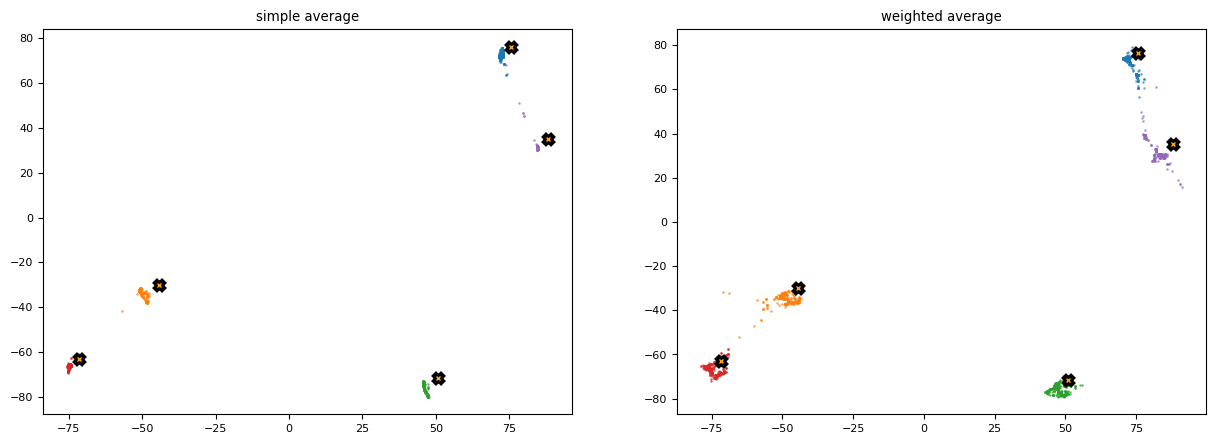

In [101]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
axs[0].set_title('simple average')
axs[1].set_title('weighted average')
plot_data(cent+4, X1, n_p,ax=axs[0])
plot_data(cent+4, X2, n_p,ax=axs[1])

In [102]:
def one_update_lsh():
    global X
    X = update_X_LSH(nns_mat, X)

In [103]:
def do_one(d):
    if d: one_update_lsh()
    ax.clear()
    plot_data(cent+4, X, n_p, ax=ax)

In [104]:
X = dat.clone()
n_hash = 20
weighted = False

X_hash = hash_X(X, n_hash, sf=0.04)
nns_coll, nns_mat = nns_LSH(X_hash, 15)
if weighted: nns_mat = nns_mat*weights_LSH(nns_coll, nns_mat, n_hash)
    
fig, ax = plt.subplots(figsize=(10,8))
ani = FuncAnimation(fig, do_one, frames=30, interval=70, repeat=False)
plt.close()
HTML(ani.to_jshtml())

In [105]:
def meanshift(data, func):
    X = data.clone()
    for i in range(3):
        weights,_ = calculate_weights(X, func)
        X = update_X(X, weights)
    return X

In [122]:
%timeit -n 2 _ = meanshift(dat, gaussian)

65.4 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [123]:
%time X = meanshift(dat, partial(gaussian,sig=10))

CPU times: user 584 ms, sys: 39.1 ms, total: 623 ms
Wall time: 156 ms


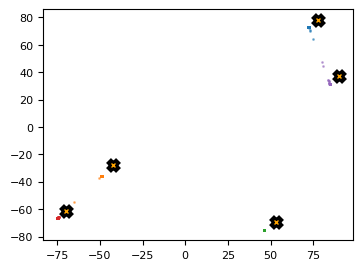

In [106]:
plot_data(cent+6, X, n_samples)

**Note**: With LSH, extracting the clusters and their center of gravity can be obtained by hashing the resulting X tensor. The points should be tightly grouped and be each in a different bucket.

The meanshift algorithm is powerful because the use of a gaussian function to weight the points contributions is easily calculated once the distance is obtained. With LSH, to get the same qualitative convergence at each iteration, we would need to update the nns list, meaning rehash the data every time. The LSH version should be useful for large high dimentional datasets.

#### GPU acceleration

In [38]:
bs = 5
X = dat.clone()
X.shape

torch.Size([1500, 2])

In [39]:
def calculate_w_gpu(Xb, X):
    D = Xb[:,None,:] - X
#     dist = torch.sqrt(torch.einsum('ijk,ijk->ij',D,D)
    return gaussian(torch.sqrt(torch.einsum('ijk,ijk->ij',D,D)), 8)

In [40]:
W = calculate_w_gpu(X[:bs], X)

In [41]:
W.shape, X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [42]:
def update_X_gpu(X, W): return (W@X)/(W.sum(1)[:,None])

In [43]:
update_X_gpu(X,W)

tensor([[73.74667, 78.36337],
        [73.61698, 69.41563],
        [74.47889, 76.21080],
        [71.21902, 74.05275],
        [73.61444, 72.77907]])

In [44]:
(W@X).shape

torch.Size([5, 2])

In [45]:
X[slice(5,5+bs)] - X[5:10]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [46]:
def meanshift_gpu(data, bs):
    X = data.clone()
    n = X.shape[0]
    for it in range(5):
        for i in range(0,n,bs):
            s = slice(i, min(i+bs,n))
            W = calculate_w_gpu(X[s], X)
            X[s] = update_X_gpu(X, W)
    return X

Test on the cpu:

In [47]:
dat = dat.cpu()

In [118]:
%time X = meanshift_gpu(dat, bs)

CPU times: user 2.09 s, sys: 166 ms, total: 2.26 s
Wall time: 567 ms


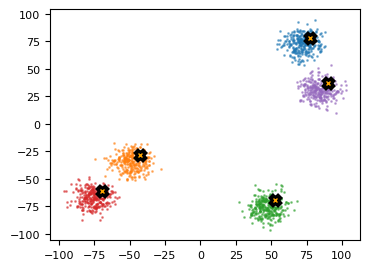

In [48]:
plot_data(cent+6, X, n_samples)

On the gpu:

In [120]:
torch.cuda.empty_cache()

In [121]:
dat = dat.cuda()

In [123]:
%timeit -n 2 _ = meanshift_gpu(dat, bs=1500)

2.13 ms ± 394 µs per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [124]:
%time X = meanshift_gpu(dat, bs=1500)

CPU times: user 3.31 ms, sys: 642 µs, total: 3.95 ms
Wall time: 3.34 ms


In [125]:
X.device

device(type='cuda', index=0)

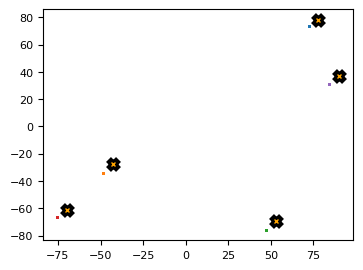

In [126]:
plot_data(cent+6, X.cpu(), n_samples)

We can use directly the previous implementation, however, it will be necessary to have a batchsize when the data is too large.

In [127]:
def meanshift(data, func):
    X = data.clone()
    for i in range(3):
        weights,_ = calculate_weights(X, func)
        X = update_X(X, weights)
    return X

In [128]:
%timeit -n 3 _ = meanshift(dat, gaussian)

1.32 ms ± 382 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)


The gain in speed is impressive. 
> Let's try with a much larger dataset with 10 dimensions (we won't try on the CPU as is because it breaks) and compare the results between meanshift and meanshift LSH:

In [49]:
n_cent = 7
n_p = 3000
dim = 10
cent = torch.rand(n_cent, dim)*500-250
cent.shape, cent

(torch.Size([7, 10]),
 tensor([[ -86.42703, -200.62793,  -86.26494, -170.19479, -170.38171,  153.30060,  -34.63724, -202.11220,  105.42810,  111.94025],
         [ 217.25696,  167.59662,  -96.08110,  190.62833,  -17.45065, -200.90961,  169.28851,   93.25983,   87.70029,  108.07895],
         [-152.78598,  140.97964,  124.35446, -105.87004,   -9.24286,   24.84143,    3.46678,  203.56985,  146.50409,   41.92221],
         [ 126.20743, -146.34363,  124.35577, -161.18631, -150.10373,  -80.70871,  191.96994,  -29.29109,   -5.95847,  240.98734],
         [-137.46906,  197.77380, -249.57204, -212.05762,  186.50308,   77.04999,   26.94617,  -10.03432,  235.08096, -181.82623],
         [-108.99750,  -23.14180,  -63.46465, -129.82300, -189.19701,  248.76440,  -58.53000, -231.64931,   80.41180,   39.47333],
         [-213.79662, -228.99690,   87.23077,  -42.32312,   64.68246, -160.30869,  -48.62311,  109.87555, -183.42688,  133.04224]]))

In [50]:
# def generate_points(c, n_pts, var): return MultivariateNormal(c, torch.diag(tensor([var,var,var,var,var,var,var,var,var,var]))).sample((n_pts,))

In [51]:
def generate_points(c, n_pts, dim, var): return MultivariateNormal(c, torch.diag(torch.full((dim,),var))).sample((n_pts,))

In [52]:
var = 50.
dat_l = [generate_points(c,n_p,dim,var) for c in cent]
dat = torch.cat(dat_l)

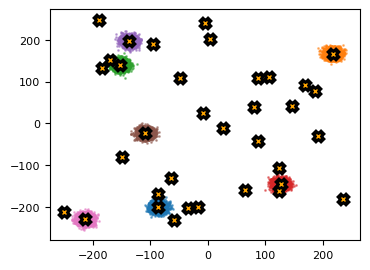

In [53]:
plot_data(cent,dat,n_p)

In [135]:
# import gc

In [136]:
# gc.collect()

In [137]:
# torch.cuda.empty_cache()

In [54]:
dat = dat.cuda()#.half()

In [139]:
%time X = meanshift_gpu(dat, bs=512)

CPU times: user 33.9 s, sys: 23.6 s, total: 57.5 s
Wall time: 57.5 s


In [55]:
dat.device

device(type='cuda', index=0)

We need to modify the Data_hash class to cast all needed tensors to the GPU:

In [56]:
class Data_hash():
    def __init__(self, data, dim, n_hash, scale_factor=1, store_hash=False, n_matches=None): 
        self.data, self.d, self.n_h, self.s = (data, dim, n_hash, scale_factor)
        h_t = 2*torch.pi*torch.rand(n_hash)
        if dim == 2: self.h_mat = torch.stack([torch.cos(h_t), -torch.sin(h_t)]).cuda()#.half()
        else: self.h_mat = (torch.rand((dim, n_hash))-0.5).cuda()#.half()
        self.h_b = torch.rand(n_hash).cuda()#.half()
        self.hashed = self._hash(data)
        self.stored = False
        if store_hash:
            self.hash_dict = {}
            if n_matches: 
                self._store(n_matches)
                self._n_matches = n_matches
            else: 
                self._store(n_hash)
                self._n_matches = n_hash
            self.stored=True
        
    def _hash(self, X): return torch.floor(X @ self.h_mat * self.s + self.h_b)
    
    def _store(self, n_matches):
        for t in self.hashed:
            if tuple(t.tolist()) in self.hash_dict.keys(): continue
            k = tuple(t.tolist())
            idx = torch.where((t == self.hashed).sum(1)>n_matches)[0]
            self.hash_dict[k]=idx.tolist()
    
    def find_nns(self, x, n_matches, idx=None):
        # idx is used to find nns in a sub point ensemble given by the indexes 'idx'
        # find_nns will get the stored buckets if they exist and if the n_matches param
        # is equal to the init param n_matches, otherwise it will perform the comparison
        x_hash = self._hash(x)
        if idx!=None :
            v_collide = (x_hash == self.hashed[idx]).sum(1)
            nns = idx[torch.where(v_collide >= n_matches)[0]]
        else:
            if self.stored and n_matches==self._n_matches:
                bucket = self.hash_dict[tuple(x_hash.tolist())]
                return _, torch.tensor(bucket)
            v_collide = (x_hash == self.hashed).sum(1)
            nns = torch.where(v_collide >= n_matches)[0]
        return v_collide, nns 
    
    
    def plot_hd(self):
        fig, ax = plt.subplots(figsize=(3,3))
        xs = torch.linspace(-1.5,1.5,10)
        ax.scatter(*self.h_mat, s=1)
        for i,a in enumerate(self.h_mat[1]/self.h_mat[0]): 
            ax.plot(xs, a*xs, linewidth=1, alpha=0.5, color='C7')
            for j in torch.arange(-5,6):
                b = (self.h_b[i]+j)*(torch.sin(torch.arctan(a))+1/a*torch.cos(torch.arctan(a)))/self.s
                ax.plot(xs, -1/a*xs + b, linewidth=0.5, alpha=0.2, color='C1')
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2);

In [57]:
def nns_LSH_gpu(xh, X_h, n_match):
    nns_bool = (xh[:,None,:] == X_h[None,...])
    nns_coll = nns_bool.sum(2)
    return nns_coll, torch.where(nns_coll>=n_match, 1,0)

In [58]:
def update_X_LSH(nns_mat, X):
    return nns_mat.float()@X / nns_mat.sum(1)[:,None]
#     return torch.einsum('ijk,jk->ik', nns_mat[...,None].float(), X)/nns_mat.sum(1)[:,None]

We need to introduce a batch size here again, we can separate the NNS search first and

In [59]:
def meanshift_LSH_gpu(X, X_hash, n_match, bs=1024, it=3):
    n = X.shape[0]
#     nns_coll = torch.zeros(n,n).cuda()#.half()
    nns_mat = torch.zeros(n,n).cuda()#.half()
    for i in range(0,n,bs):
        s = slice(i, min(i+bs,n))
#         nns_coll[s], nns_mat[s] = nns_LSH_gpu(X_hash[s], X_hash, n_match)
        _, nns_mat[s] = nns_LSH_gpu(X_hash[s], X_hash, n_match)
#     print(nns_coll)
#     print(nns_mat)
    for k in range(it):
        for i in range(0,n,bs):
            s = slice(i, min(i+bs,n))
            X[s] = update_X_LSH(nns_mat[s], X)
#             print(X)
    return X

In the version below, the nns_mat is not stored in memory in advance. It is necessary to remove any dependency to the size of the dataset to perform the operations by batch size without running out of memory:

In [60]:
def meanshift_LSH_gpu_(X, X_hash, n_match, bs=1024, it=3):
    n = X.shape[0]
#     nns_coll = torch.zeros(n,n).cuda().half()
#     nns_mat = torch.zeros(n,n).cuda().half()
    for k in range(it):
        for i in range(0,n,bs):
            s = slice(i, min(i+bs,n))
#             if k == 0 :
#             _, nns_mat[s] = nns_LSH_gpu(X_hash[s], X_hash, n_match)
            _, nns_mat_s = nns_LSH_gpu(X_hash[s], X_hash, n_match)
            X[s] = update_X_LSH(nns_mat_s, X)
    return X

In [63]:
X = dat.clone()
X_hash = hash_X(X, 20, sf=0.04)

In [64]:
X_hash

tensor([[ 3.,  0., -4.,  ..., -2.,  0., -4.],
        [ 3.,  0., -4.,  ..., -2.,  1., -5.],
        [ 3.,  0., -4.,  ..., -2.,  1., -4.],
        ...,
        [ 6.,  5.,  7.,  ..., -5., -3.,  0.],
        [ 6.,  4.,  7.,  ..., -4., -3., -1.],
        [ 6.,  4.,  6.,  ..., -4., -4.,  0.]], device='cuda:0')

In [66]:
%time X = meanshift_LSH_gpu(X, X_hash, 15, bs=512, it=15)

CPU times: user 1.12 s, sys: 812 ms, total: 1.93 s
Wall time: 712 ms


In [149]:
%time _ = meanshift_LSH_gpu_(X, X_hash, 15, bs=512, it=15)

CPU times: user 31.6 s, sys: 28.7 s, total: 1min
Wall time: 1min


In [301]:
%time X = meanshift_gpu(dat, bs=1024)

CPU times: user 29.3 s, sys: 25.5 s, total: 54.8 s
Wall time: 54.8 s


We note however that the speed is much higher when the nns matrix is already in memory. When performing a profiling with `nvprof`, one can compare see time used by the `cudaMemcpyAsync` and `cudaLaunchKernel` CUDA functions in each case, `meanshift_LSH_gpu_` has a latency time in seconds. <br>

To understand the difference and know how to reduce the latency, we need a better knowledge of the CUDA programming principles and gpu profiling. <br>
(see [1](https://stackoverflow.com/questions/6500905/techniques-to-reduce-cpu-to-gpu-data-transfer-latency), [2](https://developer.nvidia.com/blog/optimizing-data-transfer-using-lossless-compression-with-nvcomp/), [3](https://towardsdatascience.com/optimize-pytorch-performance-for-speed-and-memory-efficiency-2022-84f453916ea6), [4](https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html#using-tracing-functionality), [5](https://gist.github.com/sonots/5abc0bccec2010ac69ff74788b265086), [6](https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/), [7](https://stackoverflow.com/questions/13743039/about-cudamemcpyasync-function)).

In [67]:
def distance_calc(X, bs):
    n = X.shape[0]
    dist = torch.zeros(n,n)
    for i in range(0,n,bs):
        s = slice(i,min(i+bs,n))
        D = X[s,None,:] - X
        dist[s] = torch.einsum('ijk,ijk->ij', D, D).sqrt()
    return dist

In [68]:
dist = distance_calc(X, bs=1024)

In [84]:
def extract_clusters(X, dist, eps):
    clus_members = {}
    clus_coord = {}
    check_pts = torch.zeros(X.shape[0])
    clu_mat = dist < eps
    k = 0
    for i in range(X.shape[0]):
        if check_pts[i]: continue
        idx = torch.where((clu_mat[i].long()@clu_mat.long()))[0]
        clus_members[k] = idx
        clus_coord[k] = X[idx].mean(dim=0)
        check_pts[idx] = 1
        k += 1
    return clus_coord, clus_members

In [70]:
clu_coord, clu_mem = extract_clusters(X, dist)

In [71]:
clu_coord

{0: tensor([ -86.55078, -200.67969,  -86.85742, -170.23828, -170.64062,  152.87891,  -34.52930, -201.93750,  105.58009,  111.07813],
        device='cuda:0'),
 1: tensor([ 217.62137,  167.45312,  -95.71679,  190.72658,  -17.56494, -200.71878,  169.26170,   93.68748,   87.80079,  107.83803],
        device='cuda:0'),
 2: tensor([ 236.47156,  170.70679,  -85.59396,  184.68599,  -28.53082, -178.16957,  177.09897,   98.00257,   91.31084,   97.04012],
        device='cuda:0'),
 3: tensor([-152.22839,  141.62109,  124.97852, -105.41991,  -10.36548,   25.00000,    3.64960,  203.99219,  145.80859,   41.97656],
        device='cuda:0'),
 4: tensor([ 125.22656, -146.73047,  123.69141, -160.88281, -149.84375,  -81.59689,  192.10545,  -29.06934,   -6.02673,  241.60545],
        device='cuda:0'),
 5: tensor([-137.31250,  197.89844, -250.08594, -211.29688,  185.62892,   76.93072,   28.07129,   -9.67907,  235.89844, -181.75392],
        device='cuda:0'),
 6: tensor([-108.92773,  -23.21533,  -63.65820

In [72]:
cent

tensor([[ -86.42703, -200.62793,  -86.26494, -170.19479, -170.38171,  153.30060,  -34.63724, -202.11220,  105.42810,  111.94025],
        [ 217.25696,  167.59662,  -96.08110,  190.62833,  -17.45065, -200.90961,  169.28851,   93.25983,   87.70029,  108.07895],
        [-152.78598,  140.97964,  124.35446, -105.87004,   -9.24286,   24.84143,    3.46678,  203.56985,  146.50409,   41.92221],
        [ 126.20743, -146.34363,  124.35577, -161.18631, -150.10373,  -80.70871,  191.96994,  -29.29109,   -5.95847,  240.98734],
        [-137.46906,  197.77380, -249.57204, -212.05762,  186.50308,   77.04999,   26.94617,  -10.03432,  235.08096, -181.82623],
        [-108.99750,  -23.14180,  -63.46465, -129.82300, -189.19701,  248.76440,  -58.53000, -231.64931,   80.41180,   39.47333],
        [-213.79662, -228.99690,   87.23077,  -42.32312,   64.68246, -160.30869,  -48.62311,  109.87555, -183.42688,  133.04224]])

In [156]:
from sklearn.manifold import TSNE

In [157]:
n_dim = 2
tsne = TSNE(n_components=n_dim, learning_rate=1000)
tsne_out = tsne.fit_transform(X.cpu())
tsne_out.shape

(21000, 2)

In [158]:
X

tensor([[-221.92970, -229.03123,  147.00168,  ...,   28.22363, -235.62892, -209.98047],
        [-221.92967, -229.03122,  147.00194,  ...,   28.22363, -235.62891, -209.98047],
        [-221.92969, -229.03122,  147.00192,  ...,   28.22363, -235.62891, -209.98045],
        ...,
        [ -39.45605,  -43.99023, -135.48248,  ...,   43.68652,  182.13281,  208.88281],
        [ -39.45605,  -43.99024, -135.48280,  ...,   43.68652,  182.13283,  208.88283],
        [ -39.45605,  -43.99023, -135.48293,  ...,   43.68653,  182.13281,  208.88280]], device='cuda:0')

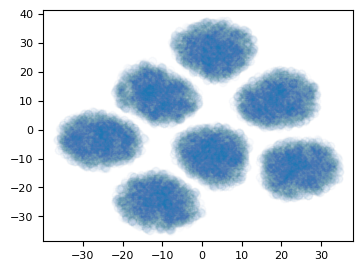

In [132]:
plt.scatter(*tsne_out.T, alpha=0.01)

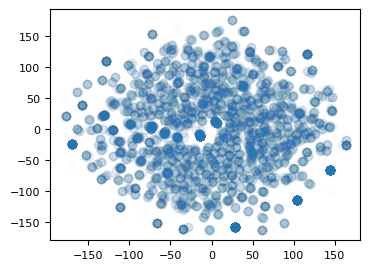

In [146]:
plt.scatter(*tsne_out.T, alpha=0.01)

In [73]:
import umap

In [74]:
reducer = umap.UMAP()

In [81]:
embed = reducer.fit_transform(X.cpu()+torch.randn_like(X.cpu()))

/home/ryvik/mambaforge/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [82]:
embed.shape

(21000, 2)

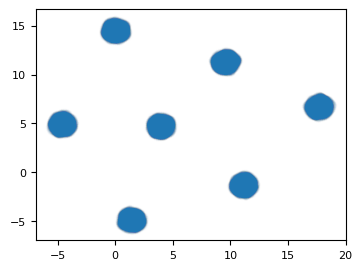

In [83]:
plt.scatter(*embed.T, alpha=0.01)

In [291]:
Xh_f = Data_hash(X, X.shape[1], 20, scale_factor=0.04, store_hash=False, n_matches=None)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_mm)

#### Quick exploration of RTrees with the rtree module - not adequate here but interesting

In [80]:
from rtree import index

In [81]:
idx = index.Index()

for i,coord in enumerate(X):
    idx.add(i, (*coord, *coord))

In [82]:
for k in range(10):
    nearest = list(idx.nearest(X[k], 2))
    nn = nearest[1]
    dist = torch.sqrt(torch.sum((X[nn]-X[k])**2))
    print (k, nn, dist)

0 53 tensor(0.00257)
1 6 tensor(0.01940)
2 85 tensor(0.00240)
3 82 tensor(0.00181)
4 110 tensor(0.00321)
5 59 tensor(0.00639)
6 27 tensor(0.00605)
7 9 tensor(0.00380)
8 48 tensor(0.00452)
9 55 tensor(0.00228)


In [224]:
tensor(list(idx.nearest(X[0], 10)))

tensor([  0,  63, 157,  61, 167, 188, 703, 142, 357,  23])

In [52]:
(X[:,None,:]-X).shape

torch.Size([10500, 10500, 2])

We can add all points to the index with a for loop:

In [38]:
def build_idx(X):
    idx = index.Index()
    for i,coord in enumerate(X):
        idx.add(i, (*coord, *coord))
    return idx

In [544]:
%timeit -n 10 build_idx(X)

822 ms ± 28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Or we can create a custom iterator to build the right data shape `(id, (minx, maxx, miny, maxy, minz, maxz, ..., ..., mink, maxk), object)` expected by the `index` object:

In [39]:
class Idx_format():
    def __init__(self, Xs):
        self.Xs = Xs
        self.step = 0
        self.max_step = Xs.shape[0]
        
    def __iter__(self):
        return self
        
    def __next__(self):
        if self.step >= self.max_step:
            raise StopIteration
        self.dat = (self.step, (*self.Xs[self.step], *self.Xs[self.step]), None)
        self.step += 1
        return self.dat

In [55]:
X_it = iter(Idx_format(X))
X_it_l = list(X_it)
X_it_l[:2]

[(0,
  (tensor(-63.21973), tensor(-2.42087), tensor(-63.21973), tensor(-2.42087)),
  None),
 (1,
  (tensor(-63.13456), tensor(-2.41613), tensor(-63.13456), tensor(-2.41613)),
  None)]

In [40]:
def build_idx(X):
    idx = index.Index()
    X_it = iter(Idx_format(X))
    idx = index.Index(list(X_it))
    return idx

In [547]:
%timeit -n 10 build_idx(X)

195 ms ± 6.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can build the nearest neighbors matrix `NN_matrix`:

- with a loop:

In [41]:
def NN_matrix(X, idx, k):
    X_nn = torch.zeros(X.shape[0], k, 2)
    for i in range(X.shape[0]):
        idxnn = list(idx.nearest(X[i], k))
        X_nn[i] = X[idxnn][:k]
    return X_nn

In [542]:
%time _ = NN_matrix(X, idx, 10) 

CPU times: user 2.85 s, sys: 99.6 ms, total: 2.95 s
Wall time: 2.36 s


- with a list comprehension:

In [537]:
%time _ = torch.stack([X[list(idx.nearest(X[i], 10))][:10] for i in range(X.shape[0])])

CPU times: user 2.39 s, sys: 0 ns, total: 2.39 s
Wall time: 2.39 s


- with a custom iterator:

In [42]:
class nn_iter():
    def __init__(self, X, idx, k):
        self.X, self.idx, self.k = X, idx, k
        self.step = 0
        self.max_step = X.shape[0]
    def __iter__(self):
        return self
    def __next__(self):
        if self.step >= self.max_step: raise StopIteration
        idxnn = list(self.idx.nearest(self.X[self.step], self.k))
        nns = self.X[idxnn][:self.k]
        self.step += 1
        return nns

In [43]:
def NN_matrix_i(X, idx, k): return torch.stack(list(iter(nn_iter(X,idx,k))))

In [540]:
%time _ = NN_matrix_i(X,idx,10)

CPU times: user 2.49 s, sys: 0 ns, total: 2.49 s
Wall time: 2.49 s


They are more or less similar, the bottleneck is the `index.Index().nearest()` method.

In [60]:
X_nn = NN_matrix(X, idx, 50) 

In [61]:
X_nn.shape, X.shape

(torch.Size([10500, 50, 2]), torch.Size([10500, 2]))

In [62]:
((X[:,None,:] - X_nn)[5]**2)[:5]

tensor([[    0.00000,     0.00000],
        [    0.00016,     0.00036],
        [    0.00006,     0.00055],
        [    0.00000,     0.00100],
        [    0.00061,     0.00043]])

In [63]:
((X[:,None,:] - X_nn)**2).sum(2).shape

torch.Size([10500, 50])

Now we use the same weight calculation function:

In [44]:
def NN_weights(X, X_nn, distrib):
    D = X[:,None,:] - X_nn
    return distrib(torch.sqrt(torch.einsum('ijk,ijk->ij',D,D)))

In [550]:
%timeit -n 10 NN_weights(X, X_nn, gaussian)

3.73 ms ± 2.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [65]:
w_nn = NN_weights(X, X_nn, gaussian)
w_nn.shape, w_nn.unique().shape

(torch.Size([10500, 50]), torch.Size([16484]))

In [66]:
X_nn.shape

torch.Size([10500, 50, 2])

In [67]:
(X_nn*w_nn[...,None]).sum(1).shape, w_nn.sum(1).shape

(torch.Size([10500, 2]), torch.Size([10500]))

In [68]:
(X_nn*w_nn[...,None]).sum(1)/w_nn.sum(1)[:,None]

tensor([[-63.21939,  -2.42252],
        [-63.13619,  -2.41427],
        [-63.08471,  -2.42567],
        ...,
        [-41.16182,  -6.74337],
        [-40.90976,  -6.57574],
        [-41.00322,  -6.58272]])

Finally the update function:

In [45]:
def update_X_nn(X_nn,W_nn): return torch.einsum('ijk,ijk->ik', X_nn, W_nn[...,None])/torch.einsum('ij->i',W_nn)[:,None] 

In [70]:
n_x = update_X_nn(X_nn, w_nn) 
n_x.shape, n_x

(torch.Size([10500, 2]),
 tensor([[-63.21939,  -2.42252],
         [-63.13620,  -2.41427],
         [-63.08472,  -2.42567],
         ...,
         [-41.16182,  -6.74337],
         [-40.90976,  -6.57574],
         [-41.00322,  -6.58272]]))

In [136]:
%%timeit -n 2
X = data.clone()

The slowest run took 110.95 times longer than the fastest. This could mean that an intermediate result is being cached.
103 µs ± 105 µs per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [558]:
%%timeit -n 2
_ = build_idx(X)

189 ms ± 2.46 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [559]:
%%timeit -n 2
_ = NN_matrix(X,idx,50)

3.41 s ± 88.3 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [560]:
%%timeit -n 2
_ = NN_weights(X, X_nn, gaussian)

5.45 ms ± 3.14 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [561]:
%%timeit -n 2
_ = update_X_nn(X_nn, nn_w)

The slowest run took 7.47 times longer than the fastest. This could mean that an intermediate result is being cached.
1.5 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [137]:
X = data.clone()
X = X[torch.randperm(X.shape[0])]

The bottleneck is the nearest neightbors matrix `NN_matrix()` calculation. The complete time for a 50 nn calculation is about 3.7s (and 100 nn about 4.57s) to be compared to 1.4s:

In [138]:
%%timeit -n 2
X = data.clone()
idx = build_idx(X)
X_nn = NN_matrix(X,idx,100)
nn_w = NN_weights(X, X_nn, gaussian)
X = update_X_nn(X_nn, nn_w)

NameError: name 'build_idx' is not defined

That said, the distance and distribution steps can be removed and an average of the nearest neighbors could be used:

In [46]:
def build_idx(X):
    idx = index.Index()
    X_it = iter(Idx_format(X))
    idx = index.Index(list(X_it))
    return idx

In [47]:
def NN_matrix(X, idx, k):
    X_nn = torch.zeros(X.shape[0], k, 2)
    for i in range(X.shape[0]):
        idxnn = list(idx.nearest(X[i], k))
        X_nn[i] = X[idxnn][:k]
    return X_nn

In [48]:
def update_X_nn_avg(X_nn): return torch.einsum('ijk->ik', X_nn)/X_nn.shape[1] 

In [571]:
%%timeit -n 2
X = data.clone()
idx = build_idx(X)
X_nn = NN_matrix(X,idx,100)
X = update_X_nn_avg(X_nn)

4.68 s ± 205 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [49]:
def meanshift_nn(data, func, k):
    X = data.clone()
    idx = build_idx(X)
    for i in range(3):
        X_nn = NN_matrix(X,idx,k)
        w_nn = NN_weights(X, X_nn, gaussian)
        X = update_X_nn(X_nn, w_nn)
    return X

In [387]:
%time meanshift_nn(data, gaussian, 500)

CPU times: user 27.3 s, sys: 313 ms, total: 27.6 s
Wall time: 25.4 s


In [76]:
X = meanshift_nn(data, gaussian, 500)

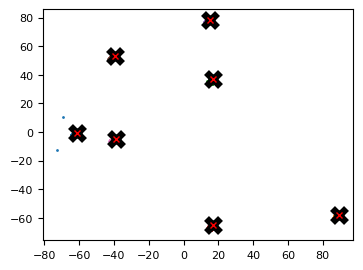

In [77]:
plot_data(centroids+2, X, n_samples)

In [78]:
X[[1,2,5]]

tensor([[-62.74137,  -2.96883],
        [-62.44592,  -2.95599],
        [-62.40714,  -1.49201]])

In [ ]:
def select_pts

In [50]:
def calculate_weights(X, distrib):
    D = X[:,None,:] - X
    return distrib(torch.sqrt(torch.einsum('ijk,ijk->ij',D,D)))

In [54]:
def update_X(X, W): return torch.einsum('jk,ijk->ik', X, W[...,None])/torch.einsum('ij->j',W)[:,None] 

In [52]:
def meanshift(data, func):
    X = data.clone()
    for i in range(3):
        weights = calculate_weights(X, func)
        X = update_X(weights, X)
    return X